# Understanding the code and loss funtion

refs:
* https://github.com/TeaPearce/Deep_Learning_Prediction_Intervals
* https://arxiv.org/pdf/1802.07167.pdf
    * High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach

**GOals**

* Understand how to train
    * y :
    * X: 
    
* Understand the loss and how it will help us


## Notes

* **findings** 

**Reviewing the paper**

* HQ: High Quality
    1. Should narrow as posisible
    1. capture the data uncertainty. The $y$ should rely on the narrow interval 

Ex: Car lentght of 1km all true values will rely on the interval. But it is not narrow.

* CIs: consider only model uncertainty
    * $Pr(f(x)|\hat{f}(X))$

* PIs: 
    * consider model + noise uncertainty: $Pr(y|\hat{f}(X))$
    * $Pi > CI$
    
The PI should capture set portion $(1 - \alpha)$ of the true values $y_1$

* $Pr(\hat{y_{Li}} \le y_i \le \hat{y_{Ui}}) \ge (1 - \alpha) $
* The vector $k$ tells each $y_i$ fall in the Pestimated PI
    * the toal number capture by the estimate PI is $c = \sum_i^n k_i$
    
* Prediction interval coverage probability:  $PICP = \frac{c}{n}$

* Mean prdiction interval width: $MPIW = \frac{1}{n} \sum_i^n \hat{y_{Li}} - \hat{y_{ui}}$

* We should minimize  MPIW with the constraint $PICP \ge (1 - \alpha)$

The cases where the PI does not capture the true value $y_i$ we do not want to shrink it, we want to make than wider or keep it constant. Because of that the author intorduced the MPIW captured.


$MPIW_{cap} = \frac{1}{c} \sum_i^n (\hat{y_{Li}} - \hat{y_{ui}}) k_i$

* Loss definition
    * Approximation $B(n, (1- \alpha)) \approx N(n(1-\alpha), n\alpha(1 - \alpha)) $  
        * requies batch size greather than 50  
    * We want minimize MPIW with the contraint $PICP < (1 - \alpha) \equiv (PCIP - (1 -\alpha)) > 0 $
    * $Loss = MPIW_{cap} + \lambda \frac{n}{\alpha (1 - \alpha)}max(0, (1-\alpha) - PCIP)^2$
        * extra penality when the $y_i$ is not in the interval: $\lambda \frac{n}{\alpha (1 - \alpha)}max(0, (1-\alpha) - PCIP)^2$
        * MPIW capture we want to minimize
        * Increase lambda penalize more due to coverage.
    * soften parameter is introduced by numerical reason so the Gradient descent can converge easily (TODO: Review later)

* Inputs:
    X: features 
    y: [y,y]


In [1]:
import IPython
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
from keras import backend as K
import tensorflow as tf

In [3]:
from utils import qd_objective, mpiw_pct, mpiw, picp,mpiw_pct_metric, mpiw_metric,picp_metric

In [6]:
# create some data
n_samples = 100
X = np.random.uniform(low=-2.,high=2.,size=(n_samples,1))
y = 1.5*np.sin(np.pi*X[:,0]) + np.random.normal(loc=0.,scale=1.*np.power(X[:,0],2))

print("5 numbers")
np.min(y)
np.mean(y)
np.max(y)
np.std(y)

y = y.reshape([-1,1])/5.

print("5 numbers")
np.min(y)
np.mean(y)
np.max(y)
np.std(y)

X_train = X.reshape(-1)
y_train = y.reshape(-1)

y_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted
x_grid = np.linspace(-2,2,100) # for evaluation plots

5 numbers


-4.931950110034318

-0.0042148931650851425

6.257800020966172

1.9977768963217117

5 numbers


-0.9863900220068637

-0.0008429786330170269

1.2515600041932344

0.3995553792643423

In [5]:
y_reshape = y.reshape([-1,1])/5.  # making column vector

# Understanding all dim
X.shape
x_grid.shape

y.shape
y_reshape.shape
y_train.shape

print()
k = 5
y[0:k]
y_train[0:k,:]

(100, 1)

(100,)

(100, 1)

(100, 1)

(100, 2)

array([[ 0.32429604],
       [ 0.7188177 ],
       [ 0.10006933],
       [ 0.22082863],
       [-0.13884454]])

array([[ 0.32429604,  0.32429604],
       [ 0.7188177 ,  0.7188177 ],
       [ 0.10006933,  0.10006933],
       [ 0.22082863,  0.22082863],
       [-0.13884454, -0.13884454]])

In [6]:
# set up model
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3), 
                bias_initializer=keras.initializers.Constant(value=[3.,-3.]))) # important to init biases to start!

# compile
opt = keras.optimizers.Adam(lr=0.02, decay=0.01)
model.compile(loss=qd_objective, optimizer=opt)

Text(0.5, 1.0, 'BEFORE training')

(-2.0, 2.0)

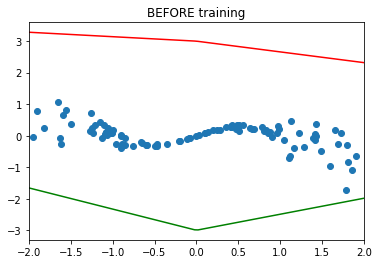

In [7]:
# plot and view some predictions
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(X_train,y_train[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
plt.title('BEFORE training')
plt.xlim(-2,2)
plt.show()

Text(0.5, 1.0, 'AFTER training 400 epochs')

(-2.0, 2.0)

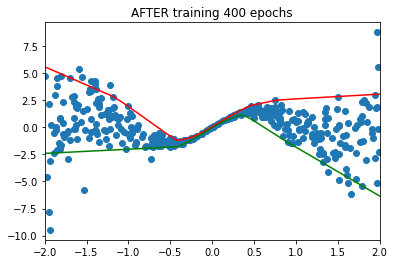

Text(0.5, 1.0, 'AFTER training 800 epochs')

(-2.0, 2.0)

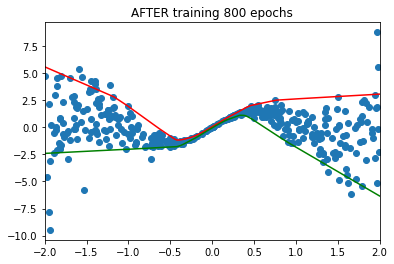

Text(0.5, 1.0, 'AFTER training 1200 epochs')

(-2.0, 2.0)

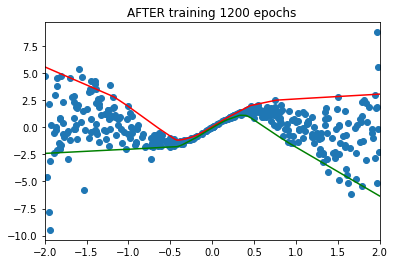

Text(0.5, 1.0, 'AFTER training 1600 epochs')

(-2.0, 2.0)

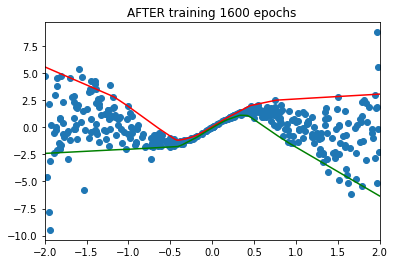

Text(0.5, 1.0, 'AFTER training 2000 epochs')

(-2.0, 2.0)

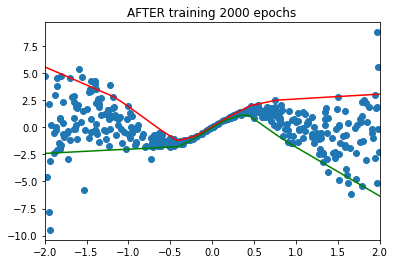

Text(0.5, 1.0, 'AFTER training 2400 epochs')

(-2.0, 2.0)

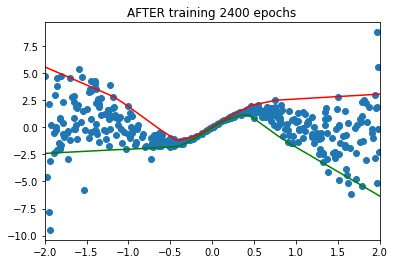

In [29]:
result_loss=[]
for i in range(6):
    result = model.fit(X_train, y_train, epochs=400, batch_size=n_, verbose=0,  validation_split=0.)
    result_loss.append(result.history['loss'])
    
    # plot and view some predictions
    y_pred = model.predict(x_grid, verbose=0)
    y_u_pred = y_pred[:,0]
    y_l_pred = y_pred[:,1]

    plt.scatter(X_train,y_train[:,0])
    plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
    plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
    plt.title('AFTER training '+str((i+1)*400)+' epochs')
    plt.xlim(-2,2)
    plt.show()

In [ ]:
# view training
result_loss = np.array(result_loss).reshape(-1)

print(f"loss last 5 values: {result_loss[-6:-1]}")

x = range(result_loss.shape[0])
plt.plot(x, result_loss, label='train')
plt.title('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,10)
plt.show()

In [ ]:
# print some stats
y_pred = model.predict(X_train, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > y_train[:,0]
K_l = y_l_pred < y_train[:,0]
print('PICP:', np.mean(K_u * K_l))
print('MPIW:', np.round(np.mean(y_u_pred - y_l_pred),3))

## Run the code with my examples

In [9]:
# create some data
n_samples = 500

X = np.random.uniform(low=-2.,high=2.,size=(n_samples,1))
y = 1.5*np.sin(np.pi*X[:,0]) + np.random.normal(loc=0.,scale=1.*np.power(X[:,0],2))

XX = X.reshape(-1)
yy = y.reshape(-1)

yy = np.stack((yy,yy),axis=1) # make this 2d so will be accepted
x_grid = np.linspace(-2,2,n_samples) # for evaluation plots

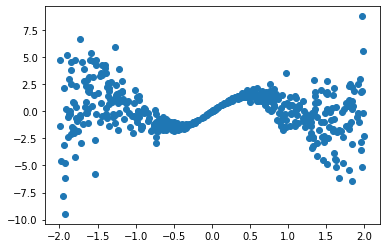

In [10]:
plt.scatter(XX,yy[:,0])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.25, random_state=42)

## Train

In [12]:
np.__version__
tf.__version__

'1.19.5'

'2.2.0'

In [80]:
# hyperparameters
lambda_ = 0.01/1e3 # lambda in loss fn
alpha_ = 0.05  # capturing (1-alpha)% of samples
soften_ = 160.
n_ = n_samples # batch size

def loss_qd(y_true, y_pred):

    return qd_objective(y_true, y_pred,n_, lambda_, alpha_, soften_)


def picp_metric_(y_true, y_pred):
    
    return picp_metric(y_true, y_pred, soften_=soften_)

def coverage_term_metric(y_true, y_pred):
    
    y_true = y_true[:,0]

    y_u = y_pred[:,0]
    y_l = y_pred[:,1]

    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    PICP_S = tf.reduce_mean(K_S)

    coverage_term = lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)
    
    return coverage_term


In [81]:
def qd_objective_debugg(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]
    
    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)
    
    print(f"K_HU: {K_HU.shape}: {K_HU}")
    print(f"K_HL: {K_HL.shape}: {K_HL}")
    print(f"K_H: {K_H.shape}: {K_H}")
    
    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    print(f"K_SU: {K_SU.shape}: {K_SU}")
    print(f"K_SL: {K_SL.shape}: {K_SL}")
    print(f"K_S: {K_S.shape}: {K_S}")
        
    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)
    
    tf.print(f"MPIW_c: {MPIW_c.shape}: {MPIW_c}")
    tf.print(f"PICP_S: {PICP_S.shape}: {PICP_S}")
    
    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)
    
    return Loss_S

def numpy_sigmoid(x):

    return 1/(1 + np.exp(-x))

def get_loss_terms(y_true, y_pred):
   
    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]
    
    K_HU = np.maximum(0., np.sign(y_u - y_true))
    K_HL = np.maximum(0.,np.sign(y_true - y_l))
    K_H = np.multiply(K_HU, K_HL)
    
#     print(f"K_HU: {K_HU.shape}: {K_HU}")
#     print(f"K_HL: {K_HL.shape}: {K_HL}")
#     print(f"K_H: {K_H.shape}: {K_H}")
    
    K_SU = numpy_sigmoid(soften_ * (y_u - y_true))
    K_SL = numpy_sigmoid(soften_ * (y_true - y_l))
    K_S = np.multiply(K_SU, K_SL)
    
    # print(f"K_SU: {K_SU.shape}: {K_SU}")
    # print(f"K_SL: {K_SL.shape}: {K_SL}")
    # print(f"K_S: {K_S.shape}: {K_S}")
        
    MPIW_c = np.sum(np.multiply((y_u - y_l),K_H))/np.sum(K_H)
    PICP_H = np.mean(K_H)
    PICP_S = np.mean(K_S)
    
    print(f"MPIW_c: {MPIW_c.shape}: {MPIW_c}")
    print(f"PICP_S: {PICP_S.shape}: {PICP_S}")
    
    term_picp =  lambda_ * n_ / (alpha_*(1-alpha_)) * np.maximum(0.,(1-alpha_) - PICP_S)
    
    Loss_S = MPIW_c + term_picp
    
    return Loss_S, MPIW_c, PICP_S, term_picp

In [82]:
y_u = np.array([1,2,3])
y_true = np.array([1,3,5])

y_u - y_true

np.max(np.concatenate([np.array([0]),np.sign(y_u - y_true)]))

np.maximum(0, np.sign(y_u - y_true))

array([ 0, -1, -2])

0

array([0, 0, 0])

In [83]:
# set up model
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3), 
                bias_initializer=keras.initializers.Constant(value=[0.5,-0.5]))) # important to init biases to start!

# compile
opt = keras.optimizers.Adam(lr=0.02, decay=0.01)
model.compile(loss=qd_objective, optimizer=opt, metrics=[mpiw_metric,coverage_term_metric,picp_metric_])

In [84]:
y_pred = model.predict(X_train[0:5], verbose=0)

y_train.shape
y_pred.shape

y_train[0:5,:]
y_pred[0:5,:]

qd_objective_debugg(y_train[0:5,:], y_pred).numpy()

(375, 2)

(5, 2)

array([[ 0.81392683,  0.81392683],
       [ 1.90069213,  1.90069213],
       [ 0.96932418,  0.96932418],
       [ 1.66461594,  1.66461594],
       [-1.0592839 , -1.0592839 ]])

array([[ 0.07812271, -0.44460538],
       [ 1.0163764 , -0.8854213 ],
       [ 0.08746737, -0.4458323 ],
       [ 0.6358261 , -0.60138005],
       [ 0.28500617, -0.47177023]], dtype=float32)

K_HU: (5,): [0. 0. 0. 0. 1.]
K_HL: (5,): [1. 1. 1. 1. 0.]
K_H: (5,): [0. 0. 0. 0. 0.]
K_SU: (5,): [7.43178164e-52 3.55997933e-62 5.27609568e-62 3.25357342e-72
 1.00000000e+00]
K_SL: (5,): [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.49750504e-41]
K_S: (5,): [7.43178164e-52 3.55997933e-62 5.27609568e-62 3.25357342e-72
 1.49750504e-41]
MPIW_c: (): nan
PICP_S: (): 2.995010079857013e-42


nan

In [85]:
%%time
result = model.fit(X_train, y_train, epochs=5000, batch_size=n_, verbose=0, validation_split=0.)

CPU times: user 15 s, sys: 2.23 s, total: 17.2 s
Wall time: 9.33 s


In [86]:
result.history["mpiw_metric"][-3:-1]
result.history["picp_metric_"][-3:-1]
result.history["coverage_term_metric"][-3:-1]

result.history["loss"][-3:-1]

[3.9154465198516846, 3.915313482284546]

[0.948713481426239, 0.948710024356842]

[0.0001354217529296875, 0.00013578565267380327]

[3.942530870437622, 3.9424707889556885]

In [87]:
y_pred = model.predict(X_train)

Loss_S, MPIW_c, PICP_S, term_picp  = get_loss_terms(y_train, y_pred)

Loss_S, MPIW_c, PICP_S, term_picp

MPIW_c: (): 3.9157192182591123
PICP_S: (): 0.9487324074562969


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


(3.9158526490531864,
 3.9157192182591123,
 0.9487324074562969,
 0.00013343079407400116)

loss last 5 values: [3.94260883 3.9426136  3.94260478 3.94253087 3.94247079]


Text(0.5, 1.0, 'Loss')

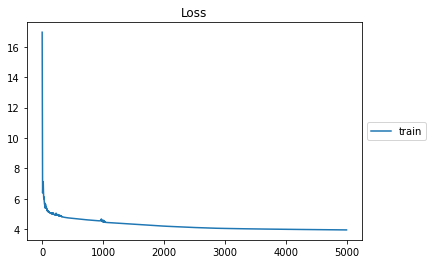

In [88]:
# view training
result_loss = np.array(result.history['loss']).reshape(-1)

print(f"loss last 5 values: {result_loss[-6:-1]}")

x = range(result_loss.shape[0])
plt.plot(x, result_loss, label='train')
plt.title('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(0,10)
plt.show()

Text(0.5, 1.0, 'AFTER training 5000 epochs')

(-2.0, 2.0)

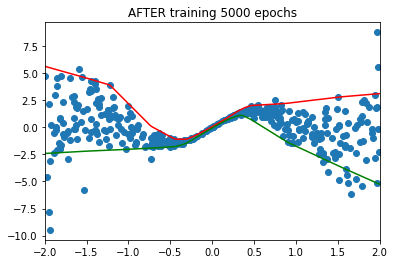

In [89]:
x_grid = np.linspace(-2,2,150) # for evaluation plots

y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(X_train,y_train[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
plt.title('AFTER training '+ str(len(result_loss)) +' epochs')
plt.xlim(-2,2)
plt.show()

Text(0, 0.5, 'mpiw_metric')

Text(0, 0.5, 'picp_metric_')

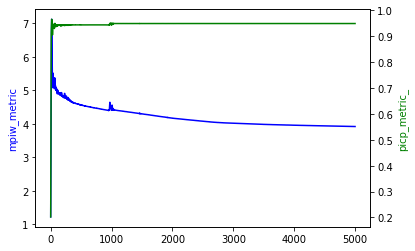

In [90]:
# view training
result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
result_picp = np.array(result.history['picp_metric_']).reshape(-1)

fig, ax1 = plt.subplots()

x = range(result_mpiw_pct.shape[0])

ax2 = ax1.twinx()
ax1.plot(x, result_mpiw, label='mpiw_metric', color='b')
ax2.plot(x, result_picp,label='picp_metric_',color='g')

# ax1.set_xlabel('X data')
ax1.set_ylabel('mpiw_metric', color='b')
ax2.set_ylabel('picp_metric_', color='g')

plt.show()

Init guess => mpiw: 1.212986707687378; coverage_term: 0.07875027507543564
Last values => mpiw: 3.91621994972229; coverage_term: 0.00013138746726326644


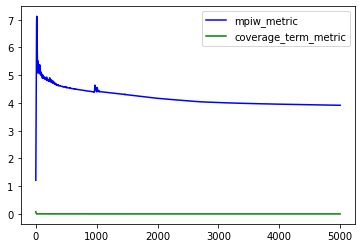

In [92]:
# view training
result_mpiw = np.array(result.history['mpiw_metric']).reshape(-1)
result_coverage_term = np.array(result.history['coverage_term_metric']).reshape(-1)


print(f"Init guess => mpiw: {result_mpiw[0]}; coverage_term: {result_coverage_term[0]}")
print(f"Last values => mpiw: {result_mpiw[-1]}; coverage_term: {result_coverage_term[-1]}")

x = range(result_mpiw.shape[0])

plt.plot(x, result_mpiw, color='b',  label='mpiw_metric') # upper boundary prediction
plt.plot(x, result_coverage_term, color='g', label='coverage_term_metric') # lower boundary prediction

plt.legend()
plt.show()

In [ ]:
# update the learning rate
print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))

K.set_value(model.optimizer.lr, 1e-3)
print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

In [ ]:
%%time
result = model.fit(X_train, y_train, epochs=1000, batch_size=n_, verbose=0,  validation_split=0.)

In [ ]:
# view training
result_loss = np.concatenate([result_loss, np.array(result.history['loss']).reshape(-1)])

print(f"loss last 5 values: {result_loss[-6:-1]}")

x = range(result_loss.shape[0])
plt.plot(x, result_loss, label='train')
plt.title('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,6)
plt.show()

In [ ]:
x = np.array([1,2,3])
y = np.array([4,5])

np.concatenate([x,y])

## Performnace

### Train

In [ ]:
# plot and view some predictions
x_grid = np.linspace(-2,2,y_pred.shape[0]) 
y_pred = model.predict(x_grid, verbose=0)  # test 
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(X_train,y_train[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
plt.title('AFTER training '+str(result_loss.shape[0])+' epochs')
plt.xlim(-2,2)
plt.show()

In [ ]:
# print some stats
y_pred = model.predict(X_train, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > y_train[:,0]
K_l = y_l_pred < y_train[:,0]

PICP_train = np.mean(K_u * K_l)
print('PICP:', PICP_train)

MPIW_train = np.round(np.mean(y_u_pred - y_l_pred),3)
print('MPIW:', MPIW_train)

PIWpct = y_train[:,0]/(y_u_pred - y_l_pred)
MPIPCT_train =  np.round(np.mean(PIWpct),3)
print('MPIPCT (y/w):', MPIPCT_train)

### test

In [ ]:
y_pred = model.predict(x_grid, verbose=0)

X_test.shape
y_test.shape

In [ ]:
# plot and view some predictions
x_grid = np.linspace(-2,2,y_pred.shape[0]) 
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(X_test,y_test[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
plt.title('AFTER training '+str((i+1)*400)+' epochs')
plt.xlim(-2,2)
plt.show()

In [ ]:
# print some stats
y_pred = model.predict(X_test, verbose=0)

PICP_test = picp(y_test,y_pred)
print('PICP:', PICP_test)

MPIW_test =  mpiw(y_test,y_pred)
print('MPIW:', MPIW_test)

PIWpct = y_test[:,0]/(y_u_pred - y_l_pred)
MPIPCT_test =  mpiw_pct(y_test,y_pred)
print('MPIPCT (y/w):', MPIPCT_test)

In [ ]:

X_test.shape
y_pred = model.predict(X_test, verbose=0)

k = 1 # 7 false but it i sokay
PIW_k = y_pred[k,0] - y_pred[k,1]
y_k = y_test[k,0]

c = y_k < y_pred[k,0] and y_k > y_pred[k,1]
print(f"{y_pred[k,1]} < {y_k} < {y_pred[k,0]}: {PIW_k}; PI%: {y_k/PIW_k} {c}")
